# **Loan Approval Prediction: Kaggle Playground Series**  
# *Score: 0.96037 AUC-ROC*

## 1. Data Loading & Initial Inspection

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train = pd.read_csv('./database/train.csv')
test = pd.read_csv('./database/test.csv')

# Initial inspection
print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
train.head(3)

Training Data Shape: (58645, 13)
Test Data Shape: (39098, 12)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0


### Target Distribution


<ipython-input-24-3a108f10cf88>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='loan_status', data=train, palette='coolwarm')


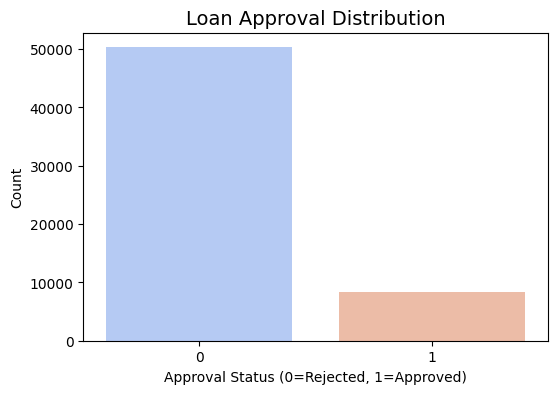

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=train, palette='coolwarm')
plt.title('Loan Approval Distribution', fontsize=14)
plt.xlabel('Approval Status (0=Rejected, 1=Approved)')
plt.ylabel('Count')
plt.show()

## 2. Feature Engineering

In [25]:
def add_features(df):
    """Create meaningful financial features"""
    # Debt-to-income ratio
    df['loan_amnt_to_income'] = df['loan_amnt'] / df['person_income']

    # Credit history interaction
    df['emp_length_credit_ratio'] = df['person_emp_length'] / (df['cb_person_cred_hist_length'] + 1)

    return df

X = train.drop(columns=['id', 'loan_status'])
y = train['loan_status']
test_ids = test['id']
test = test.drop(columns=['id'])

X = add_features(X)
test = add_features(test)

### Feature Relationships

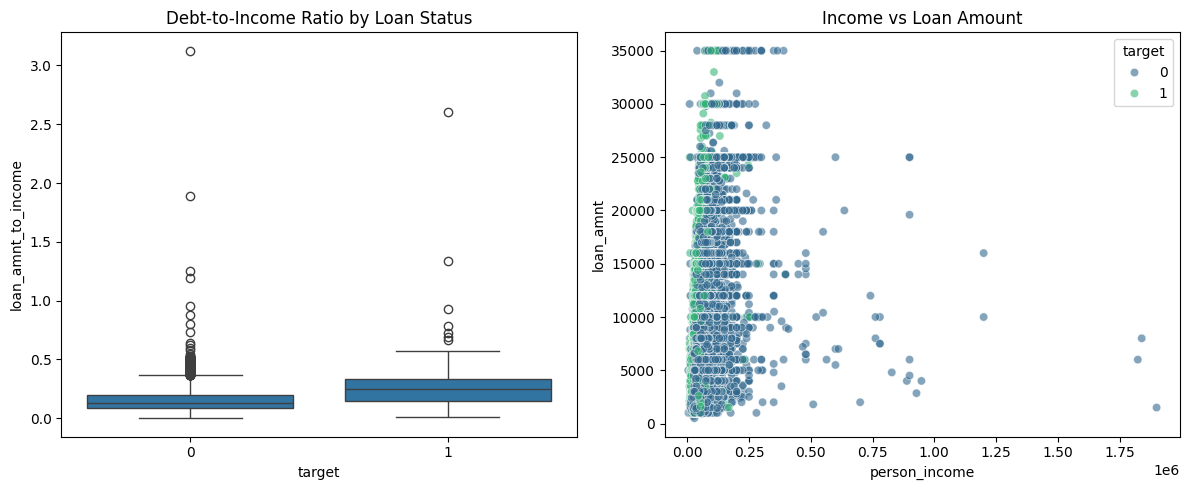

In [26]:
# Create combined dataframe for visualization
plot_df = pd.concat([X, y], axis=1).rename(columns={'loan_status': 'target'})

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='target', y='loan_amnt_to_income', data=plot_df)
plt.title('Debt-to-Income Ratio by Loan Status')

plt.subplot(1, 2, 2)
sns.scatterplot(
    x='person_income',
    y='loan_amnt',
    hue='target',
    data=plot_df,
    palette='viridis',
    alpha=0.6
)
plt.title('Income vs Loan Amount')
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [27]:
# Identify column types
numerical_cols = ['person_age', 'person_income', 'person_emp_length',
                 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
                 'cb_person_cred_hist_length', 'loan_amnt_to_income',
                 'emp_length_credit_ratio']

categorical_cols = ['person_home_ownership', 'loan_intent',
                   'loan_grade', 'cb_person_default_on_file']

### Preprocessing Pipeline

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


## 4. Model Training & Tuning

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='auc',
        random_state=42,
    ))
])

param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    model,
    param_dist,
    n_iter=10,
    cv=cv,
    scoring='roc_auc',
    verbose=2,
    random_state=42
)

search.fit(X, y)

print(f"Best Validation AUC: {search.best_score_:.4f}")
print("Optimal Parameters:")
for param, value in search.best_params_.items():
    print(f"{param.split('__')[1]}: {value}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.8; total time=   1.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.8; total time=   1.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.8; total time=   1.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.8; total time=   2.2s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=5, classifier__n_estimators=300, classifier__subsample=0.8; total time=   1.1s
[CV] END classifier__colsample_bytree=0.8, classifier__lear

## 5. Feature Importance

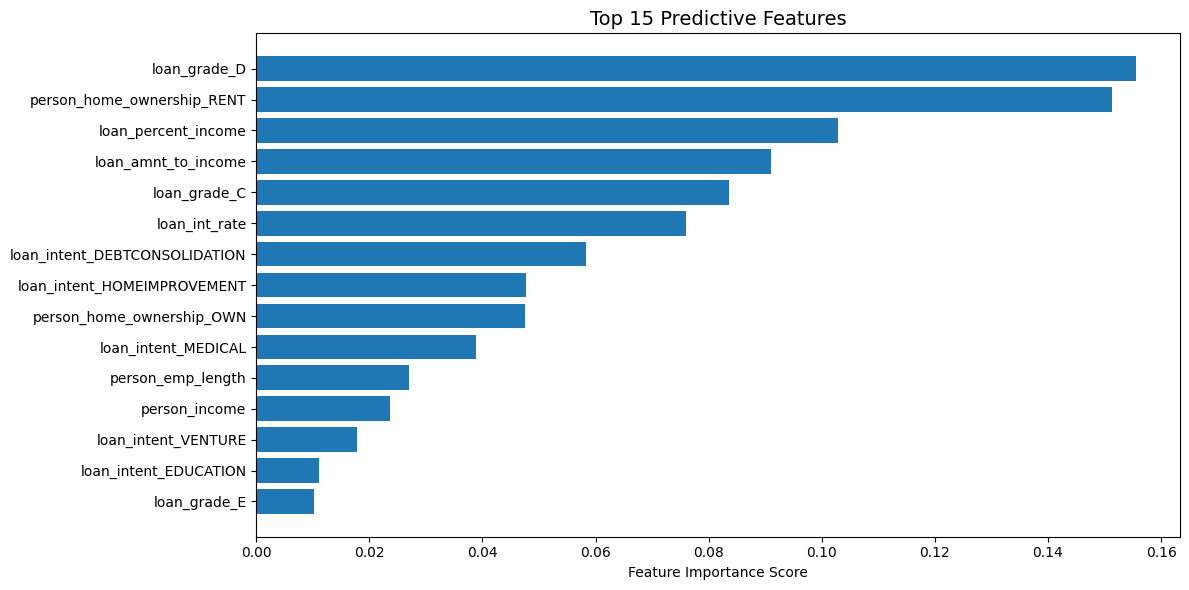

In [30]:
preprocessor.fit(X)
feature_names = numerical_cols + list(
    preprocessor.named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_cols)
)

importances = search.best_estimator_['classifier'].feature_importances_
sorted_idx = np.argsort(importances)[-15:]

plt.figure(figsize=(12, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.title('Top 15 Predictive Features', fontsize=14)
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

## 6. Final Predictions

In [31]:
best_model = search.best_estimator_
test_proba = best_model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'id': test_ids, 'loan_status': test_proba})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
print("\nSample Predictions:")
submission.head()

Submission file created successfully!

Sample Predictions:


,id,loan_status
0,58645,0.996174
1,58646,0.014483
2,58647,0.517351
3,58648,0.010454
4,58649,0.086069
